## 프로젝트 : 단어 Level로 번역기 업그레이드하기
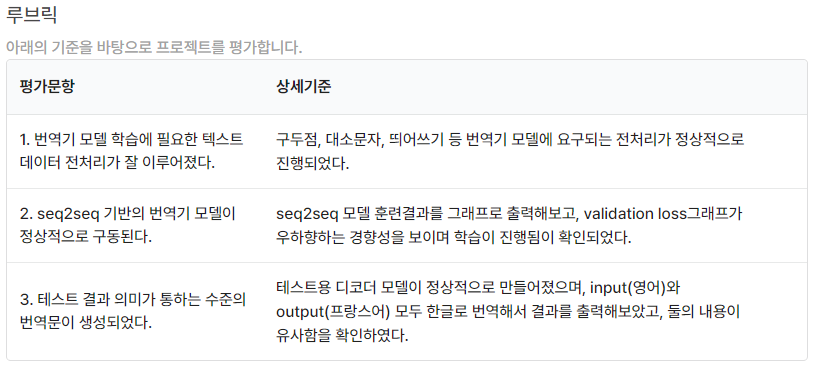

In [23]:
import os, re
import pandas as pd
import numpy as np
import tensorflow
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.utils import to_categorical

print(tensorflow.__version__)

2.6.0


### Step 1. 정제, 정규화, 전처리 (영어, 프랑스어 모두!)

In [24]:
file_path = os.getenv('HOME')+'/aiffel/translator_seq2seq/data/fra.txt'
orig = pd.read_csv(file_path, names=['eng', 'fra', 'cc'], sep='\t')
print('전체 샘플의 수 :',len(orig))
orig.sample(5) #샘플 5개 출력

전체 샘플의 수 : 208906


,eng,fra,cc
131998,She is afraid of her own shadow.,Elle a peur de son propre ombre.,CC-BY 2.0 (France) Attribution: tatoeba.org #3...
178891,That rule doesn't apply in this situation.,Cette règle ne s'applique pas dans cette situa...,CC-BY 2.0 (France) Attribution: tatoeba.org #7...
133315,Tom was killed in the explosion.,Tom a été tué dans l'explosion.,CC-BY 2.0 (France) Attribution: tatoeba.org #2...
174310,How can I upload a photo to your website?,Comment puis-je télécharger une photo sur votr...,CC-BY 2.0 (France) Attribution: tatoeba.org #2...
131607,May I eat another piece of cake?,Puis-je manger une autre part de gâteau ?,CC-BY 2.0 (France) Attribution: tatoeba.org #5...


In [25]:
lines = orig[['eng', 'fra']][:33000] # 33000개 샘플 사용
lines.sample(5)

,eng,fra
22439,What do you know?,Que sais-tu ?
9739,You're loaded.,T'es bourrée.
26904,The cops want you.,Les flics sont après toi.
1323,Kill them.,Tuez-les.
14476,I have dandruff.,J'ai des pellicules.


In [26]:
# 구두점을 단어와 분리 
lines.eng = lines.eng.apply(lambda x: re.sub(r"([!?.])", r" \1 ", x))
lines.fra = lines.fra.apply(lambda x: re.sub(r"([!?.])", r" \1 ", x))
lines.sample(5)

# lines = re.sub("([?.!,¿])", " \1 ", lines)

,eng,fra
23330,Are you the mayor ?,Êtes-vous le maire ?
13571,Can you hear us ?,Arrivez-vous à nous entendre ?
25763,Is there a remedy ?,Y a-t-il un remède ?
12246,They'll attack .,Elles attaqueront .
18909,I already did it .,Je l'ai déjà fait .


Ref.    
https://acdongpgm.tistory.com/166 데이터프레임에서 특수문자 제거   
https://ponyozzang.tistory.com/613 데이터프레임 찾아 바꾸기     
https://docs.python.org/ko/3/library/re.html 정규식 연산    
https://dojang.io/mod/page/view.php?id=2438 raw 문자열 사용하기 

In [27]:
# 소문자 전환 
lines = lines.applymap(str.lower) 
lines.sample(5)

,eng,fra
20601,my stomach hurts .,j'ai mal à l'estomac .
4078,tom left it .,tom l'a laissée .
26411,pretend you're me .,fais semblant d'être moi .
18603,he is in trouble .,il a des soucis .
1071,i grunted .,j'ai grogné .


Ref.   
https://ddangeun.tistory.com/11 데이터프레임 대소문자 전환 

### Step 2. 디코더의 문장에 시작 토큰과 종료 토큰을 넣어주세요.

In [28]:
# 시작 토큰과 종료 토큰 추가
sos_token = '<sos>'
eos_token = '<eos>'
lines.fra = lines.fra.apply(lambda x : '<sos> '+ x + ' <eos>')
print('전체 샘플의 수 :',len(lines))
lines.sample(5)

전체 샘플의 수 : 33000


,eng,fra
31148,i never forgot you .,<sos> je ne vous ai jamais oubliés . <eos>
4271,we're saved .,<sos> nous sommes sauvés . <eos>
5116,i loved that .,<sos> j'adorais ça . <eos>
8669,stop bragging .,<sos> cessez de vous vanter . <eos>
8804,the girls won .,<sos> les filles l'emportèrent . <eos>


### Step 3. 케라스의 토크나이저로 텍스트를 숫자로 바꿔보세요.

In [29]:
# 띄어쓰기 단위로 토큰화 
eng_tokenizer = Tokenizer(char_level=False)   # 단어 단위로 Tokenizer를 생성합니다. 
eng_tokenizer.fit_on_texts(lines.eng)               # 33000개의 행을 가진 eng의 각 행에 토큰화를 수행
input_text = eng_tokenizer.texts_to_sequences(lines.eng)    # 단어를 숫자값 인덱스로 변환하여 저장
input_text[:3]

[[21], [21], [21]]

char_level=True : 글자 단위 토큰화     
char_level=False : 단어 단위 토큰화, default  

Ref.   
https://yeko90.tistory.com/entry/Keras-how-to-use-Tokenizer-example 글자단위 토큰화 

In [30]:
fra_tokenizer = Tokenizer(char_level=False)  
fra_tokenizer.fit_on_texts(lines.fra)               
target_text = fra_tokenizer.texts_to_sequences(lines.fra)    
target_text[:3]

[[1, 58, 2], [1, 337, 2], [1, 22, 500, 2]]

In [31]:
eng_vocab_size = len(eng_tokenizer.word_index) + 1
fra_vocab_size = len(fra_tokenizer.word_index) + 1
print('영어 단어장의 크기 :', eng_vocab_size)
print('프랑스어 단어장의 크기 :', fra_vocab_size)

영어 단어장의 크기 : 4744
프랑스어 단어장의 크기 : 9938


In [32]:
max_eng_seq_len = max([len(line) for line in input_text])
max_fra_seq_len = max([len(line) for line in target_text])
print('영어 시퀀스의 최대 길이', max_eng_seq_len)
print('프랑스어 시퀀스의 최대 길이', max_fra_seq_len)

영어 시퀀스의 최대 길이 6
프랑스어 시퀀스의 최대 길이 14


In [33]:
print('전체 샘플의 수 :',len(lines))
print('영어 단어장의 크기 :', eng_vocab_size)
print('프랑스어 단어장의 크기 :', fra_vocab_size)
print('영어 시퀀스의 최대 길이', max_eng_seq_len)
print('프랑스어 시퀀스의 최대 길이', max_fra_seq_len)

전체 샘플의 수 : 33000
영어 단어장의 크기 : 4744
프랑스어 단어장의 크기 : 9938
영어 시퀀스의 최대 길이 6
프랑스어 시퀀스의 최대 길이 14


In [34]:
encoder_input = input_text
# 종료 토큰 제거
decoder_input = [[ char for char in line if char != fra_tokenizer.word_index['eos'] ] for line in target_text]
# decoder_input = [[ char for char in line if char != '<eos>'] for line in target_text]

# 시작 토큰 제거
decoder_target = [[ char for char in line if char != fra_tokenizer.word_index['sos'] ] for line in target_text]
# decoder_target = [[ char for char in line if char != '<sos>'] for line in target_text]

In [35]:
print(decoder_input[:3])
print(decoder_target[:3])

[[1, 58], [1, 337], [1, 22, 500]]
[[58, 2], [337, 2], [22, 500, 2]]


In [36]:
encoder_input = pad_sequences(encoder_input, maxlen = max_eng_seq_len, padding='post')
decoder_input = pad_sequences(decoder_input, maxlen = max_fra_seq_len, padding='post')
decoder_target = pad_sequences(decoder_target, maxlen = max_fra_seq_len, padding='post')
print('영어 데이터의 크기(shape) :',np.shape(encoder_input))
print('프랑스어 입력데이터의 크기(shape) :',np.shape(decoder_input))
print('프랑스어 출력데이터의 크기(shape) :',np.shape(decoder_target))

영어 데이터의 크기(shape) : (33000, 6)
프랑스어 입력데이터의 크기(shape) : (33000, 14)
프랑스어 출력데이터의 크기(shape) : (33000, 14)


In [37]:
print(encoder_input[0])

[21  0  0  0  0  0]


In [39]:
# 검증데이터 개수 바꿀것 
n_of_val = 3000

encoder_input_train = encoder_input[:-n_of_val]
decoder_input_train = decoder_input[:-n_of_val]
decoder_target_train = decoder_target[:-n_of_val]

encoder_input_test = encoder_input[-n_of_val:]
decoder_input_test = decoder_input[-n_of_val:]
decoder_target_test = decoder_target[-n_of_val:]

print('영어 학습데이터의 크기(shape) :',np.shape(encoder_input))
print('프랑스어 학습 입력데이터의 크기(shape) :',np.shape(decoder_input))
print('프랑스어 학습 출력데이터의 크기(shape) :',np.shape(decoder_target))

영어 학습데이터의 크기(shape) : (33000, 6)
프랑스어 학습 입력데이터의 크기(shape) : (33000, 14)
프랑스어 학습 출력데이터의 크기(shape) : (33000, 14)


### Step 4. 임베딩 층(Embedding layer) 사용하기

In [40]:
from tensorflow.keras.layers import Input, Embedding, Masking, LSTM, Dense
from tensorflow.keras.models import Model

emb_size = 256

# 인코더에서 사용할 임베딩 층 사용 예시
encoder_inputs = Input(shape=(None, ))
enc_emb = Embedding(eng_vocab_size, emb_size)(encoder_inputs)
encoder_lstm = LSTM(units = 256, return_state=True)
encoder_outputs, state_h, state_c = encoder_lstm(enc_emb)
encoder_states = [state_h, state_c]

In [41]:
# 입력 텐서 생성.
decoder_inputs = Input(shape=(None, ))
dec_emb = Embedding(fra_vocab_size, emb_size)(decoder_inputs)
# hidden size가 256인 인코더의 LSTM 셀 생성
decoder_lstm = LSTM(units = 256, return_sequences = True, return_state=True)
# decoder_outputs는 모든 time step의 hidden state
decoder_outputs, _, _= decoder_lstm(dec_emb, initial_state = encoder_states)

In [42]:
decoder_softmax_layer = Dense(fra_vocab_size, activation='softmax')
decoder_outputs = decoder_softmax_layer(decoder_outputs)

### Step 5. 모델 구현하기

In [21]:
model = Model([encoder_inputs, decoder_inputs], decoder_outputs)
model.compile(optimizer="rmsprop", loss="sparse_categorical_crossentropy")
model.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, None)]       0                                            
__________________________________________________________________________________________________
input_2 (InputLayer)            [(None, None)]       0                                            
__________________________________________________________________________________________________
embedding (Embedding)           (None, None, 256)    1214464     input_1[0][0]                    
__________________________________________________________________________________________________
embedding_1 (Embedding)         (None, None, 256)    2544128     input_2[0][0]                    
______________________________________________________________________________________________

In [22]:
from keras.callbacks import EarlyStopping

early_stopping = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=3)

In [43]:
history_lstm = model.fit(x=[encoder_input_train, decoder_input_train], y=decoder_target_train, \
          validation_data = ([encoder_input_test, decoder_input_test], decoder_target_test),
          batch_size=128, epochs=50, callbacks=[early_stopping])

Epoch 1/50
235/235 [==============================] - 10s 24ms/step - loss: 1.9472 - val_loss: 2.0229
Epoch 2/50
235/235 [==============================] - 5s 21ms/step - loss: 1.4592 - val_loss: 1.7649
Epoch 3/50
235/235 [==============================] - 5s 21ms/step - loss: 1.2502 - val_loss: 1.6362
Epoch 4/50
235/235 [==============================] - 5s 21ms/step - loss: 1.1340 - val_loss: 1.5582
Epoch 5/50
235/235 [==============================] - 5s 21ms/step - loss: 1.0522 - val_loss: 1.4974
Epoch 6/50
235/235 [==============================] - 5s 21ms/step - loss: 0.9840 - val_loss: 1.4581
Epoch 7/50
235/235 [==============================] - 5s 21ms/step - loss: 0.9234 - val_loss: 1.4221
Epoch 8/50
235/235 [==============================] - 5s 21ms/step - loss: 0.8715 - val_loss: 1.3913
Epoch 9/50
235/235 [==============================] - 5s 21ms/step - loss: 0.8258 - val_loss: 1.3801
Epoch 10/50
235/235 [==============================] - 5s 21ms/step - loss: 0.7838 - val_l

In [44]:
history_dict = history_lstm.history
print(history_dict.keys()) # epoch에 따른 그래프를 그려볼 수 있는 항목들

dict_keys(['loss', 'val_loss'])


In [53]:
loss = history_dict['loss']
val_loss = history_dict['val_loss']

epochs = range(1, len(loss) +1)

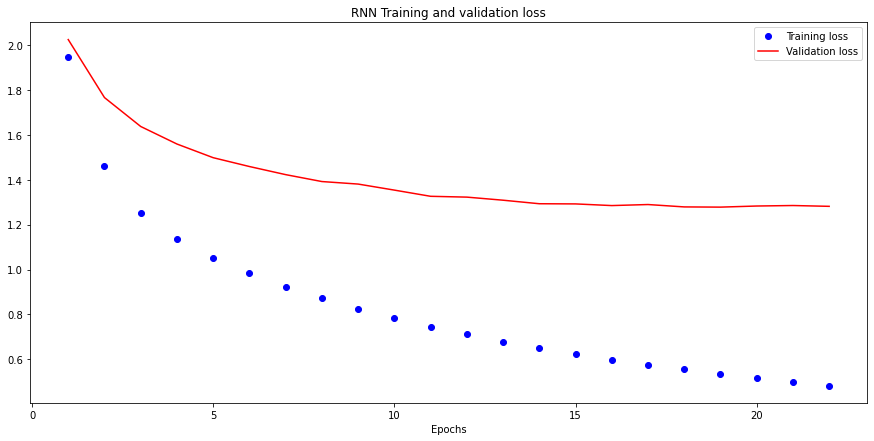

In [54]:
import matplotlib.pyplot as plt

plt.figure(figsize = (15, 7))

plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'r', label='Validation loss')
plt.title('RNN Training and validation loss')
plt.xlabel('Epochs')
plt.legend()

plt.show()  

### Step 6. 모델 평가하기

In [55]:
encoder_model = Model(inputs = encoder_inputs, outputs = encoder_states)
encoder_model.summary()

Model: "model_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_3 (InputLayer)         [(None, None)]            0         
_________________________________________________________________
embedding_2 (Embedding)      (None, None, 256)         1214464   
_________________________________________________________________
lstm_2 (LSTM)                [(None, 256), (None, 256) 525312    
Total params: 1,739,776
Trainable params: 1,739,776
Non-trainable params: 0
_________________________________________________________________


In [56]:
# 이전 time step의 hidden state를 저장하는 텐서
decoder_state_input_h = Input(shape=(256,))
# 이전 time step의 cell state를 저장하는 텐서
decoder_state_input_c = Input(shape=(256,))
# 이전 time step의 hidden state와 cell state를 하나의 변수에 저장
decoder_states_inputs = [decoder_state_input_h, decoder_state_input_c]


dec_emb_test = Embedding(fra_vocab_size, emb_size)(decoder_inputs)

# decoder_states_inputs를 현재 time step의 초기 상태로 사용.
# 구체적인 동작 자체는 def decode_sequence()에 구현.
decoder_outputs, state_h, state_c = decoder_lstm(dec_emb_test, initial_state = decoder_states_inputs)
# 현재 time step의 hidden state와 cell state를 하나의 변수에 저장.
decoder_states = [state_h, state_c]

In [57]:
decoder_outputs = decoder_softmax_layer(decoder_outputs)
decoder_model = Model(inputs=[decoder_inputs] + decoder_states_inputs, outputs=[decoder_outputs] + decoder_states)
decoder_model.summary()

Model: "model_2"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_4 (InputLayer)            [(None, None)]       0                                            
__________________________________________________________________________________________________
embedding_4 (Embedding)         (None, None, 256)    2544128     input_4[0][0]                    
__________________________________________________________________________________________________
input_5 (InputLayer)            [(None, 256)]        0                                            
__________________________________________________________________________________________________
input_6 (InputLayer)            [(None, 256)]        0                                            
____________________________________________________________________________________________

In [58]:
eng2idx = eng_tokenizer.word_index
fra2idx = fra_tokenizer.word_index
idx2eng = eng_tokenizer.index_word
idx2fra = fra_tokenizer.index_word

In [59]:
def decode_sequence(input_seq):
    # 입력으로부터 인코더의 상태를 얻음
    states_value = encoder_model.predict(input_seq)

    # <SOS>에 해당하는 원-핫 벡터 생성
    target_seq = np.zeros((1, 1))
    target_seq[0, 0] = fra2idx['sos']

    stop_condition = False
    decoded_sentence = ""

    # stop_condition이 True가 될 때까지 루프 반복
    while not stop_condition:
        # 이점 시점의 상태 states_value를 현 시점의 초기 상태로 사용
        output_tokens, h, c = decoder_model.predict([target_seq] + states_value)

        # 예측 결과를 문자로 변환
        sampled_token_index = np.argmax(output_tokens[0, -1, :])
        sampled_char = idx2fra[sampled_token_index]

        # 현재 시점의 예측 문자를 예측 문장에 추가
        decoded_sentence += sampled_char

        # <eos>에 도달하거나 최대 길이를 넘으면 중단.
        if (sampled_char == 'eos' or
           len(decoded_sentence) > max_fra_seq_len):
            stop_condition = True

        # 현재 시점의 예측 결과를 다음 시점의 입력으로 사용하기 위해 저장
        target_seq = np.zeros((1, 1))
        target_seq[0, 0] = sampled_token_index

        # 현재 시점의 상태를 다음 시점의 상태로 사용하기 위해 저장
        states_value = [h, c]

    return decoded_sentence

In [61]:
import numpy as np

for i in range(10):
    random_index = np.random.randint(1, 33000)
    input_seq = encoder_input[random_index: random_index + 1]
    decoded_sentence = decode_sequence(input_seq)

    print(35 * "-")
    print('입력 문장:', lines.eng[random_index])
    print('정답 문장:', lines.fra[random_index][6:-6])
    print('번역기가 번역한 문장:', decoded_sentence[:-3])

-----------------------------------
입력 문장: are you there ? 
정답 문장: t'es là  ? 
번역기가 번역한 문장: négocieambitie
-----------------------------------
입력 문장: it's cloudy . 
정답 문장: le temps est couvert . 
번역기가 번역한 문장: négociefaçonsfaç
-----------------------------------
입력 문장: put on your shoes . 
정답 문장: enfilez vos chaussures . 
번역기가 번역한 문장: pattesarrivécomm
-----------------------------------
입력 문장: plug that leak up . 
정답 문장: bouche cette fuite . 
번역기가 번역한 문장: spécialparieong
-----------------------------------
입력 문장: take it easy ! 
정답 문장: ne t'en fais pas . 
번역기가 번역한 문장: idiotevieuximpuissa
-----------------------------------
입력 문장: i'm happy with it . 
정답 문장: j'en suis heureux . 
번역기가 번역한 문장: aimonsaventureu
-----------------------------------
입력 문장: tom hates dogs . 
정답 문장: tom déteste les chiens . 
번역기가 번역한 문장: pantalonsloinaman
-----------------------------------
입력 문장: let me go ! 
정답 문장: laissez-moi y aller  ! 
번역기가 번역한 문장: pantalonsjugem
-----------------------------------
입력 문장: i 

번역한 문장에 띄어쓰기가 없고 영 이상하다. 

## 회고

**헤맨 부분** 
- 에러가 너무 다양하고 많아서 일일히 나열하기 힘들정도다. 순식간에 이것저것 바꾸면 다른 에러가 나와서 미처 정리하지 못한게 대부분이다. 
- 마지막 번역한 문장을 출력할 때, 정답 문장에서 계속 시작, 종료 토큰이 사라지지 않는다. 원인을 발견하지 못해서 다른 코드로 바꿔버렸다. 

**문제를 해결하기 위한 시도와 원인 추론**
- 구두점을 단어와 분리하는 부분에서 시간이 많이 걸렸다. 작곡가 프로젝트에서 했던대로 re.sub을 썼더니 문자열이었던 그때와 달리 데이터프레임이라 에러가 났다. 여러가지 시도를 해봤지만 에러가 안나도 막상 적용되지는 않았다. lines의 열을 기준으로 했어야하는데, lines 변수명에 중복으로 적용해서 난 에러였다. 
- 작곡가 노드에 나왔던대로 lines.replace로 했을 때는 TypeError: expected string or bytes-like object 에러가 났다. lines가 문자열이 아니라 pandas dataframe이라 발생한 에러다. 


**새롭게 알게된 부분**
- [from nltk.tokenize import word_tokenize](https://jaejune0625.tistory.com/32)를 이용하면 자동으로 구두점, 띄어쓰기 기준으로 토큰화해준다.
- embedding vector 하이퍼파라미터다 

**아직도 모르는 부분**
- 이번 프로젝트는 너무 어려워서 전반적으로 왜 이런 코드를 쓰는지, 과정이 어떻게 진행되는지 잘 모르겠다. 